In [63]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.metrics import euclidean_distances
from sklearn.utils import check_random_state, check_array, check_symmetric
#from sklearn.externals.joblib import Parallel, delayed, effective_n_jobs
from sklearn.isotonic import IsotonicRegression

def NMDSfunc(dissimilarities, n_dimensions=2, max_iter=300, verbose=False, eps=1e-3, random_state=None):
    '''
    dissimilarities: matrix
    eps: used for convergence
    '''
    dissimilarities = check_symmetric(dissimilarities, raise_exception=True)
    n_samples = dissimilarities.shape[0]
    random_state = check_random_state(random_state)

    sim_flat = ((1 - np.tri(n_samples)) * dissimilarities).ravel()
    sim_flat_w = sim_flat[sim_flat != 0]
    #Random initial configuration
    X = random_state.rand(n_samples * n_dimensions)
    X = X.reshape((n_samples, n_dimensions))

    old_stress = None
    ir = IsotonicRegression()
    for it in range(max_iter):
        # Compute distance and monotonic regression
        dis = euclidean_distances(X)
        dis_flat = dis.ravel()
        dis_flat_w = dis_flat[sim_flat != 0]

        # Find disparities using monotonic regression
        disparities_flat = ir.fit_transform(sim_flat_w, dis_flat_w)
        disparities = dis_flat.copy()
        disparities[sim_flat != 0] = disparities_flat
        disparities = disparities.reshape((n_samples, n_samples))
        disparities *= np.sqrt((n_samples * (n_samples - 1) / 2) / (disparities ** 2).sum())
        # Compute stress
        stress = ((dis.ravel() - disparities.ravel()) ** 2).sum() / 2

        # Update X using the Guttman transform
        dis[dis == 0] = 1e-5
        ratio = disparities / dis
        B = - ratio
        B[np.arange(len(B)), np.arange(len(B))] += ratio.sum(axis=1)
        X = 1. / n_samples * np.dot(B, X)

        dis = np.sqrt((X ** 2).sum(axis=1)).sum()
        if verbose:
            print('iteration: %d, stress %s' % (it, stress))
        if old_stress is not None:
            if(old_stress - stress / dis) < eps:
                if verbose:
                    print('convergence: breaking at iteration %d with stress %s' % (it,stress))
                break
        old_stress = stress / dis

    return X, stress, it + 1


def NMDS(dissimilarities, n_dimensions=2, n_init=4,
            max_iter=300, verbose=False, eps=1e-3, random_state=None):
    """
    Multiple(n_init) iterations to find the best stress at a particular dimension
    """
    dissimilarities = check_array(dissimilarities)
    random_state = check_random_state(random_state)

    best_pos, best_stress = None, None
    for it in range(n_init):
        pos, stress, n_iter_ = NMDSfunc(dissimilarities, n_dimensions=n_dimensions, max_iter=max_iter, verbose=verbose,
                eps=eps, random_state=random_state)
        #print(pos)
        print(stress)
        if best_stress is None or stress < best_stress:
            best_stress = stress
            best_pos = pos.copy()
            best_iter = n_iter_
            
    return best_pos, best_stress, best_iter


class MDS():
    def __init__(self, n_dimensions=2,  n_init=4,
                 max_iter=300, verbose=False, eps=1e-3,
                 random_state=None):
        self.n_dimensions = n_dimensions
        self.n_init = n_init
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose
        self.random_state = random_state

    def fit(self, X, y=None):
      
        #self.fit_transform(X)
        X = check_array(X)
        self.dissimilarity_matrix_ = X
        
        self.embedding, self.stress, self.n_iter = NMDS(self.dissimilarity_matrix_,
            n_dimensions=self.n_dimensions, n_init=self.n_init,
            max_iter=self.max_iter, verbose=self.verbose,
            eps=self.eps, random_state=self.random_state)
        
        return self

In [64]:
sim = np.array([[0, 5, 3, 4],
                [5, 0, 2, 2],
                [3, 2, 0, 1],
                [4, 2, 1, 0]])
mds_clf = MDS()
a = mds_clf.fit(sim)

0.00455517706873
0.00568620527718
0.00360615225171
0.00216097996829


In [65]:
a.stress

0.0021609799682891944

In [66]:
a.embedding

array([[-0.51171021, -0.12542663],
       [ 0.50459287,  0.09042339],
       [ 0.04074435, -0.29824396],
       [-0.04095825,  0.3481076 ]])

In [67]:
sim2 = np.array([[0, 1, 4, 5, 3, 4, 2, 8, 8, 5, 7, 1],
                [1, 0, 3, 8, 2, 6, 2, 7, 8, 8, 7, 2],
                [4, 3, 0, 7, 2, 3, 3, 7, 8, 6, 4, 3],
                [5, 8, 7, 0, 8, 9, 3, 8, 2, 2, 9, 5],
                [3, 2, 2, 8, 0, 6, 4, 8, 9, 6, 4, 2],
                [4, 6, 3, 9, 6, 0, 1, 3, 9, 8, 5, 3],
                [2, 2, 3, 3, 4, 1, 0, 4, 3, 6, 7, 1],
                [8, 7, 7, 8, 8, 3, 4, 0, 9, 6, 9, 5],
                [8, 8, 8, 2, 9, 9, 3, 9, 0, 4, 9, 9],
                [5, 8, 6, 2, 6, 8, 6, 6, 4, 0, 4, 3],
                [7, 7, 4, 9, 4, 5, 7, 9, 9, 4, 0, 6],
                [1, 2, 3, 5, 2, 3, 1, 5, 9, 3, 6, 0]])
mds_2 = MDS(n_dimensions=4)
b = mds_2.fit(sim2)


0.763746574026
0.94772071077
0.52778551819
0.612545026295


In [68]:
b.stress

0.52778551818987518

In [69]:
output = []
for i in range(1,15):
    model = MDS(n_dimensions=i)
    b = model.fit(sim2)
    output.append(b)


5.00819593764
5.52146148815
4.66860175973
4.05828817639
2.37781219487
2.12287849908
2.32413494542
3.14245920246
0.827824971442
0.887896083388
1.44874899525
1.37563201384
0.648641795892
0.868577490965
0.33417083569
0.937689612324
0.434484652225
0.310639960646
0.607136444039
0.594548555239
0.384825930397
0.632477534911
0.409056291966
0.281648969797
0.406314332752
0.27979877505
0.134718314875
0.315800252407
0.134931210885
0.231837198166
0.244590567412
0.272076108706
0.19600683592
0.189796325615
0.187995777286
0.117379841531
0.199954489019
0.147362356211
0.134880828786
0.15248717618
0.134828689347
0.128596621855
0.139388384365
0.13577860186
0.129695375957
0.11246954555
0.149057286608
0.104720124687
0.170505341848
0.146778627885
0.117009980621
0.158717010155
0.114406309315
0.1113715348
0.0885778377139
0.0923920837029


/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:3363: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)


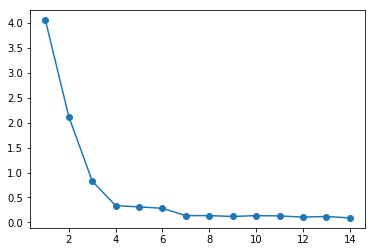

In [70]:
val = []
for i in range(0,14):  
    val.append(output[i].stress)
    
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
 
# data
df=pd.DataFrame({'x': range(1,15), 'y': val })
 
# plot
plt.plot( 'x', 'y', data=df, linestyle='-', marker='o')
plt.show()

def test():
    
    pass


In [71]:
import pandas as pd
a = pd.read_csv('SimilarityMatrixv2.csv')
dsim = (7 - a.drop(a.columns[0], axis = 1)).values

#nmds = MDS(n_dimensions=40)
#ans = mds_2.fit(dsim)

output = []
for i in range(1,15):
    nmds = MDS(n_dimensions=i)
    ans = nmds.fit(dsim)
    output.append(ans)

78.5237158739
79.2784597931
77.3008417192
82.4872030963
42.302973482
42.0451248482
40.3402766153
40.548247862
26.7339070389
26.7394743407
26.0174760662
28.2639111554
18.6850665394
19.0841525689
18.1727936688
18.5699894924
14.2066201644
13.9815737761
14.3241305904
13.9097419346
11.0714995106
10.8148759028
10.7302878397
11.3485628382
8.9779451307
8.56500845281
8.79172555992
8.65955135808
7.24071649623
7.23523451084
7.19467841665
7.949994226
6.16178562989
6.53421039345
6.77502054704
6.37508238008
5.63803480758
5.79014128899
5.06466118455
5.34802394817
4.88722917939
4.90468127308
5.08301652506
4.65575744383
4.42563377649
4.86586864834
4.54261385989
4.29180192514
3.98653723781
4.07181457298
3.87411746507
3.88596800503
3.29427928511
3.71037410443
3.67326346378
3.76534537269


In [19]:
#ans.stress

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:3363: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)


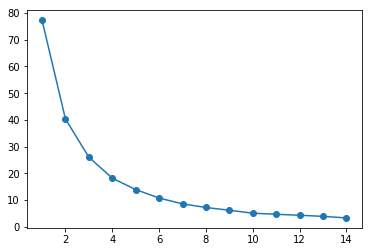

In [72]:
val = []
for i in range(0,14):  
    val.append(output[i].stress)
    
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
 
# data
df=pd.DataFrame({'x': range(1,15), 'y': val })
 
# plot
plt.plot( 'x', 'y', data=df, linestyle='-', marker='o')
plt.show()

In [73]:
dsim

array([[ 0.        ,  4.        ,  4.33333333, ...,  4.33333333,
         4.33333333,  5.        ],
       [ 4.        ,  0.        ,  3.75      , ...,  3.75      ,
         1.        ,  4.5       ],
       [ 4.33333333,  3.75      ,  0.        , ...,  2.        ,
         0.        ,  6.        ],
       ..., 
       [ 4.33333333,  3.75      ,  2.        , ...,  0.        ,
         1.        ,  4.66666667],
       [ 4.33333333,  1.        ,  0.        , ...,  1.        ,
         0.        ,  4.        ],
       [ 5.        ,  4.5       ,  6.        , ...,  4.66666667,
         4.        ,  0.        ]])

In [74]:
nmds2 = MDS(n_dimensions=2)
ans2 = nmds2.fit(dsim)

'''
from sklearn.decomposition import PCA
clf = PCA(n_components=2)
npos = clf.fit_transform(ans2.embedding)
'''


42.0082560198
42.4882221459
41.7259074083
42.8233451522


'from matplotlib import pyplot as plt\nfrom sklearn.decomposition import PCA\nclf = PCA(n_components=2)\nnpos = clf.fit_transform(ans2.embedding)\n'

In [78]:
npos = ans2.embedding
npos

array([[ 0.31855113, -0.28290583],
       [-0.4422423 ,  0.22351462],
       [-0.2962667 , -0.35794507],
       [ 0.35709287, -0.20986451],
       [-0.09457334, -0.33337227],
       [ 0.16760777, -0.18258983],
       [ 0.04370836,  0.00939073],
       [-0.17284697,  0.40373039],
       [ 0.09636717, -0.10246264],
       [-0.50311454,  0.13543435],
       [-0.18856297,  0.33468434],
       [ 0.23208835, -0.05370863],
       [-0.34364369,  0.31999141],
       [-0.20051255,  0.43556844],
       [-0.39692461,  0.35985433],
       [-0.43987459,  0.16638172],
       [ 0.46675789,  0.37747402],
       [ 0.09327363, -0.46614479],
       [-0.09576913,  0.53987312],
       [-0.43919553, -0.02754971],
       [ 0.28059283, -0.00809379],
       [-0.34712018,  0.09874525],
       [ 0.30702628,  0.30668251],
       [ 0.01142276,  0.13413732],
       [ 0.06051942,  0.29873569],
       [ 0.20726983,  0.37915334],
       [-0.22764273,  0.23939746],
       [-0.37033762, -0.10898261],
       [-0.06456685,

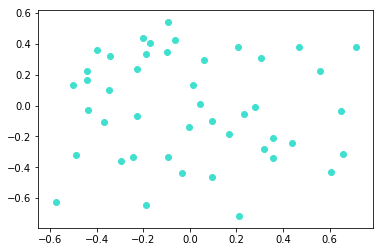

In [77]:
from matplotlib import pyplot as plt
plt.scatter(npos[:, 0], npos[:, 1], color='turquoise',  label='NMDS')
plt.show()

In [100]:
## labels for pairs
labels_pairs = ['ac', 'aa', 'ar', 'at', 'bh', 'buh', 'de', 'dro', 'dra', 
                'dc', 'et', 'fb', 'frc', 'fuc', 'gat', 'gd', 'ge' ,'gs',
                'grt', 'hd', 'hs', 'im', 'ms' , 'mc', 'mt', 'pa', 'pb',
                'ps', 'rs', 'rp', 'rv', 'rd', 'sk', 'se', 'ss', 'st', 'tl',
                'tt', 'te', 'tm', 'vr', 'wr', 'wd', 'wm', 'wl']
len(set(labels_pairs))

45

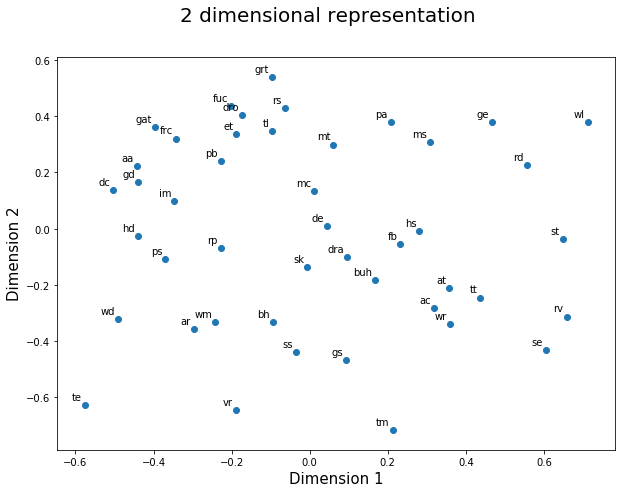

In [101]:
fig = plt.figure(figsize=(10, 7))
fig.suptitle('2 dimensional representation', fontsize = 20)
plt.xlabel('Dimension 1',fontsize = 15)
plt.ylabel('Dimension 2',fontsize = 15)
plt.subplots_adjust(bottom=0.1)  
plt.scatter(npos[:, 0], npos[:, 1], label='True Position')

for label, x, y in zip(labels_pairs, npos[:, 0], npos[:, 1]):  
    plt.annotate(label, xy=(x, y), xytext=(-3, 3), textcoords='offset points', ha='right', va='bottom')
plt.show()  